Original Code

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random
from data_helper import read_csv

%matplotlib widget

# Plot data again 
csv_data = read_csv('data.csv')

uCi = 3.7 * (10**10) * (10**(-6))
year = 3.154*(10**7)
pi = np.pi

activity_0 = 57 * uCi
u_activity_0 = 0.5 * uCi
half_life = 87.7 * year
u_half_life = 0.05 * year
age = 54 * year
u_age = (1/24)*year

activity_expected = activity_0 * np.exp(-np.log(2)*age/half_life)
u_activity_expected = activity_expected * np.sqrt((u_activity_0/activity_0)**2 + (u_age/age)**2 + (u_half_life/half_life)**2)

inch = 2.54 #cm
amu = 1.6605390689*(10**-24)

density = 19.283 #g/cm3
mass_Au = 196.96657 * amu #g

e_0 = 55.26349406 * (10**6) * 10000 #e2 MeV-1 cm-1
k = 1/(4*pi*e_0)
q = 2 #e
Q = 79 #e
E = 5 #MeV
u_E = 0.5


E_squared = E**2
u_E_squared = E_squared*2*u_E/E

z_expected = 0.0002 * inch
u_z_expected = 0.00005 * inch

n_tar = density*z_expected/mass_Au
u_n_tar = density*u_z_expected/mass_Au

A_expected = n_tar*((k*q*Q/(4))**2)/E_squared
u_A_expected = A_expected* np.sqrt((u_n_tar/n_tar)**2 + (u_E_squared/E_squared)**2)

xs_min = 1.10 + 0.6 #cm, min distance + thumbscrew thickness
xd_min = 3.66 #cm
z_Au = 0.0005 #cm, or 0.0002 in
d_Au = 0.1 #cm, or 0.040 in
d_Pu = 1.3 #cm
d_det = 0.7 #cm


c = 3 * 10**10 #cm/s
m_alpha = (3.727379 * 10**3)/(c*c) #MeV/c2
E_alpha = 5 #MeV
dE_alpha = 1 #MeV, energy lost in gold

# returns speed of particle in cm/s from kinetic energy E (MeV) and mass (MeV/c2)
def speed(E, m):
    return np.sqrt(2*E/m)

s_alpha = speed(E_alpha, m_alpha)
s2_alpha = speed(E_alpha-dE_alpha, m_alpha)

# Alpha partilce object. Contains kinematic variables needed for simulation
class Alpha:
    def __init__(self, t, x, v):
        self.t = t
        self.x = x
        self.v = v

    # returns radial position
    def r(self):
        return np.sqrt(self.x[0]**2 + self.x[1]**2)
    
    # return spherical components of velocity: speed, theta, phi
    def v_sph(self):
        s = np.linalg.norm(self.v)
        theta = np.arccos(self.v[2]/s)
        phi = np.arccos(self.v[0]/(s*np.sin(theta)))
        return np.array([s, theta, phi])

    # given z position and diameter of target (centered at r = 0), returns True and updates position+time if alpha hits target 
    def hit(self, z_targ, d_targ):
        if self.v[2] <= 0:
            return False
        delt = (z_targ-self.x[2])/self.v[2]
        self.t += delt
        self.x = np.add(self.x, delt*self.v)
        return self.r() < d_targ/2
    
    def update(self, t):
        delt = t - self.t
        self.x = np.add(self.x, delt*self.v)
        self.t = t
    
    # given change in speed and scattering angle, updates velocity
    def deflect(self, ds, dtheta, dphi):
        #create basis around self.v
        s = np.linalg.norm(self.v)
        th = self.v_sph()[1]
        v = self.v/s
        d = np.array([1,0,0])
        u = np.cross(v,np.add(v,d))
        u = u/np.linalg.norm(u)
        w = np.cross(v,u)

        # Create basis transformations
        B = np.array([u, w, v]).transpose() #Change of basis matrix v-basis -> standard

        # Create vector in v basis in spherical coordiantes with rotations
        v_B = np.array([np.sin(dtheta) * np.cos(dphi), np.sin(dtheta) * np.sin(dphi), np.cos(dtheta)])

        # transform back to standard basis and update v
        self.v = (s+ds) * np.matmul(B, v_B)
        
        

# Creates alpah particle with random position (uniform in area of disc-shaped source) and direction (uniform in +z direction)
def generate(t):
    r = (d_Pu/2) * np.sqrt(random.random())
    x_phi = (2*pi) * random.random()
    v_theta = np.arccos(random.random())
    v_phi = (2*pi) * random.random()
    x = np.array([r*np.cos(x_phi), r*np.sin(x_phi), 0])
    v = s_alpha * np.array([np.sin(v_theta)*np.cos(v_phi), np.sin(v_theta)*np.sin(v_phi), np.cos(v_theta)])
    return Alpha(t, x, v)

# checks if alphas hit foil, scatters alphas uniformly in solid angle, then checks if alphas hit detector
def uniform_scatter(a, xd, xs):
    dtheta = None
    hit_detector = False
    path = [a.x]
    hit_foil = a.hit(xs_min + xs, d_Au)
    if hit_foil:
        dtheta =  np.arccos(random.uniform(-1,1))
        dphi = (2*pi) * random.random()
        ds = s2_alpha - s_alpha
        path.append(a.x)
        a.deflect(ds, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
        if hit_detector:
            path.append(a.x)
    return [hit_foil, hit_detector, dtheta, path]

# checks if alphas hit foil, scatters alphas uniformly in solid angle, then checks if alphas hit detector
# instead of choosing random scattering angle, chooses random outgoing angle, and calculates scattering angle after the fact
def uniform_scatter2(a,xd, xs):
    dtheta = None
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    path = [a.x]
    if hit_foil:
        path.append(a.x)
        theta =  np.arccos(random.uniform(-1,1))
        phi = (2*pi) * random.random()
        new_v = s2_alpha * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        dtheta = np.arccos(np.dot(a.v, new_v)/(s_alpha*s2_alpha))
        a.v = new_v
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
        if hit_detector:
            path.append(a.x)
    return [hit_foil, hit_detector, dtheta, path]



# checks if alphas hit foil, scatters alphas with rutherford distribution (given normalization), then checks if alphas hit detectors
def rutherford_scatter(a, xd, xs, A):
    dtheta = None
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    path = [a.x]
    if hit_foil:
        path.append(a.x)
        # mininum scattering angle (min_theta) determiend by normalization of differential cross section from min_theta to pi, with factor of A
        min_f = -1-2*A #f(min_theta)
        max_f = -2*A #f(pi)
        f = random.uniform(min_f, max_f) #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
        dtheta =  2*np.arcsin(np.sqrt(-(2*A)/f)) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
        dphi = random.uniform(0, 2*pi)
        ds = s2_alpha - s_alpha
        a.deflect(ds, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
        if hit_detector:
            path.append(a.x)
    return [hit_foil, hit_detector, dtheta, path]

# checks if alphas hit foil, scatters alphas with rutherford distribution modified by incidence angle, then checks if alphas hit detectors
def rutherford_scatter2(a, xd, xs, A):
    dtheta = None
    hit_detector = False
    hit_foil = a.hit(xs_min + xs, d_Au)
    path = [a.x]
    if hit_foil:
        path.append(a.x)
        A = A/np.cos(a.v_sph()[1]) # distance through gold = target thickness weighted by secant of angle of incidence
        # mininum scattering angle (min_theta) determiend by normalization of differential cross section from min_theta to pi, with factor of A
        min_f = -1-2*A #f(min_theta)
        max_f = -2*A #f(pi)
        f = random.uniform(min_f, max_f) #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
        dtheta =  2*np.arcsin(np.sqrt(-(2*A)/f)) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
        dphi = random.uniform(0, 2*pi)
        ds = s2_alpha - s_alpha
        a.deflect(ds, dtheta, dphi)
        hit_detector = a.hit(xs_min + xs + xd_min + xd, d_det)
        if hit_detector:
            path.append(a.x)
    return [hit_foil, hit_detector, dtheta, path]


In [2]:
Au_distance = 0.407 * 10**-7
b_max = Au_distance/2
theta_min = 2*np.arctan((k*q*Q)/(2*5.5*b_max))
u_max= -2
u_min =-2*(1/np.sin(theta_min/2))**2

print(z_expected)

0.000508


Vectorized Simulation Functions

In [3]:

def simulate1(xd, xs, N, N_dot):
    rng = np.random.default_rng()  # Use NumPy's faster random number generator
    t = np.arange(0,N)/N_dot  # Generate all times at once

    # Generate all particles at once
    r = (d_Pu / 2) * np.sqrt(rng.random(N))  # Radial position
    x_phi = 2 * np.pi * rng.random(N)  # Azimuthal angle
    v_theta = np.arccos(rng.random(N))  # Polar angle
    v_phi = 2 * np.pi * rng.random(N)  # Azimuthal velocity direction

    x = np.column_stack((r * np.cos(x_phi), r * np.sin(x_phi), np.zeros(N)))  # Initial positions
    v = s_alpha * np.column_stack((
        np.sin(v_theta) * np.cos(v_phi),
        np.sin(v_theta) * np.sin(v_phi),
        np.cos(v_theta)
    ))  # Initial velocities

    # Compute hitting foil
    hit_time = (xs_min + xs - x[:, 2]) / v[:, 2]
    hit_positions = x + hit_time[:, np.newaxis] * v
    hit_radii = np.sqrt(hit_positions[:, 0] ** 2 + hit_positions[:, 1] ** 2)
    hit_foil = (v[:,2] > 0) * (hit_radii < d_Au / 2)
    t = t[hit_foil] + hit_time[hit_foil]

    # Scattering
    dtheta = np.arccos(rng.uniform(-1, 1, size=np.sum(hit_foil)))
    #dtheta = rng.uniform(0, pi, size=np.sum(hit_foil))
    dphi = rng.uniform(0, 2 * np.pi, size=np.sum(hit_foil))
    ds = s2_alpha - s_alpha

    itheta = np.arccos(v[hit_foil,2]/s_alpha)

    # Update velocities after scattering
    v_scattered = np.column_stack((
        np.sin(dtheta) * np.cos(dphi),
        np.sin(dtheta) * np.sin(dphi),
        np.cos(dtheta)
    )) * s2_alpha

    # Compute hitting detector
    hit_time_det = (xs_min + xs + xd_min + xd - hit_positions[hit_foil, 2]) / v_scattered[:, 2]
    hit_positions_det = hit_positions[hit_foil] + hit_time_det[:, np.newaxis] * v_scattered
    hit_radii_det = np.sqrt(hit_positions_det[:, 0] ** 2 + hit_positions_det[:, 1] ** 2)
    hit_detector = (v_scattered[:, 2] > 0) * (hit_radii_det < d_det / 2)
    t = t[hit_detector] + hit_time_det[hit_detector]




    # Count results
    N_hit_foil = np.sum(hit_foil)
    N_hit_det = np.sum(hit_detector)
    N_scattered = np.sum((1/(np.sin(dtheta/2))**4))/(N_hit_foil)
    #N_detected = np.sum((np.sin(dtheta[hit_detector]))*(1/(np.sin(dtheta[hit_detector]/2))**4)/np.cos(itheta[hit_detector]))/(N_scattered)
    #N_detected = (N_hit_det/N_hit_foil)*N_scattered
    N_detected = np.sum((1/(np.sin(dtheta[hit_detector]/2))**4))/(N_hit_foil)
    print("hit foil " + str(N_hit_foil))
    print("hit det " + str(N_hit_det))
    print("scattered " + str(N_scattered))
    print("detected " + str(N_detected))
    # if len(t) > 0:
    #     T = max(max(t), N/N_dot)
    # else:
    #     T = N/N_dot
    T = N/N_dot
    if N_hit_det > 0:
        u_N_detected = 0.5 * N_detected / N_hit_det
    else:
        u_N_detected = 0
    return N_detected / T, 0.5/T, T, N_hit_foil, N_hit_det, N_detected, (x[hit_foil])[hit_detector], (hit_positions[hit_foil])[hit_detector], hit_positions_det[hit_detector], dtheta, np.average(itheta)


In [41]:
def simulate2(xd, xs, N, min_theta):
    rng = np.random.default_rng()  # Use NumPy's faster random number generator
    t = np.arange(0,N)  # Generate all times at once

    # Generate all particles at once
    r = (d_Pu / 2) * np.sqrt(rng.random(N))  # Radial position
    x_phi = 2 * np.pi * rng.random(N)  # Azimuthal angle
    v_theta = np.arccos(rng.random(N))  # Polar angle
    v_phi = 2 * np.pi * rng.random(N)  # Azimuthal velocity direction

    x = np.column_stack((r * np.cos(x_phi), r * np.sin(x_phi), np.zeros(N)))  # Initial positions
    v = s_alpha * np.column_stack((
        np.sin(v_theta) * np.cos(v_phi),
        np.sin(v_theta) * np.sin(v_phi),
        np.cos(v_theta)
    ))  # Initial velocities

    # Compute hitting foil
    hit_time = (xs_min + xs - x[:, 2]) / v[:, 2]
    hit_positions = x + hit_time[:, np.newaxis] * v
    hit_radii = np.sqrt(hit_positions[:, 0] ** 2 + hit_positions[:, 1] ** 2)
    hit_foil = (v[:,2] > 0) * (hit_radii[:] < d_Au / 2)
    t = t[hit_foil] + hit_time[hit_foil]

    # Scattering
    min_f = -2/(np.sin(min_theta/2))**2
    max_f = -2 #f(pi)
     #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
    f = rng.uniform(min_f, max_f, size=np.sum(hit_foil))
    dtheta =  2*np.arcsin(np.sqrt(-(2)/f)) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
    dphi = rng.uniform(0, 2*np.pi, size=np.sum(hit_foil))
    dtheta[0] =pi/6

    #create basis around self.v
    itheta = np.arccos(v[hit_foil,2]/s_alpha)
    n = v[hit_foil] / np.linalg.norm(v[hit_foil], axis=1, keepdims=True)  # Normalize original velocity vectors

       # Create an arbitrary perpendicular vector `u` that is not parallel to n
    d = np.where(np.abs(n[:, 0:1]) < 0.99, [1, 0, 0], [0, 1, 0])  
    u = np.cross(n, d)  # Perpendicular to n
    u /= np.linalg.norm(u, axis=1, keepdims=True)  # Normalize u

    # Create the second perpendicular vector `w`
    w = np.cross(n, u)  # Perpendicular to both u and n
    w /= np.linalg.norm(w, axis=1, keepdims=True)  # Normalize w

    print(dtheta)
    # Construct the rotated velocity in the local frame
    v_scattered = (
        np.sin(dtheta)[:, None] * (np.cos(dphi)[:, None] * u + np.sin(dphi)[:, None] * w) +
        np.cos(dtheta)[:, None] * n
    ) 
    print(n[0])
    print(v_scattered[0])

    fig = plt.figure()
    ax1 = fig.add_subplot(projection='3d')

    ax1.quiver(0,0,0, n[0,0], n[0,1], n[0,2], length=.1)
    ax1.quiver(0,0,0, u[0,0], u[0,1], u[0,2], length=.1, color = 'green')
    ax1.quiver(0,0,0, w[0,0], w[0,1], w[0,2], length=.1, color = 'green')
    #ax1.quiver(0,0,0, v_B[0], v_B[1], v_B[2], length=0.00000000001, color = 'orange')
    #ax1.quiver(0,0,0, 0, 0, 1, length=0.00000000001, color = 'orange')
    ax1.quiver(0,0,0, v_scattered[0,0], v_scattered[0,1], v_scattered[0,2], length=.1, color='red')
    v_scattered *= s2_alpha

    # Compute hitting detector
    hit_time_det = (xs_min + xs + xd_min + xd - hit_positions[hit_foil, 2]) / v_scattered[:, 2]
    hit_positions_det = hit_positions[hit_foil] + hit_time_det[:, np.newaxis] * v_scattered
    hit_radii_det = np.sqrt(hit_positions_det[:, 0] ** 2 + hit_positions_det[:, 1] ** 2)
    hit_detector = (v_scattered[:, 2] > 0) * (hit_radii_det < d_det / 2)
    t = t[hit_detector] + hit_time_det[hit_detector]

    # Count results
    N_scattered = np.sum(hit_foil)
    N_hit = np.sum(hit_detector)
    N_detected = np.sum(hit_detector)

    return N_detected, 0.5


In [5]:
#rutherford distribution but not normalized

def simulate3(xd, xs, N, N_dot):
    rng = np.random.default_rng()  # Use NumPy's faster random number generator
    t = np.arange(0,N)/N_dot  # Generate all times at once

    # Generate all particles at once
    r = (d_Pu / 2) * np.sqrt(rng.random(N))  # Radial position
    x_phi = 2 * np.pi * rng.random(N)  # Azimuthal angle
    v_theta = np.arccos(rng.random(N))  # Polar angle
    v_phi = 2 * np.pi * rng.random(N)  # Azimuthal velocity direction

    x = np.column_stack((r * np.cos(x_phi), r * np.sin(x_phi), np.zeros(N)))  # Initial positions
    v = s_alpha * np.column_stack((
        np.sin(v_theta) * np.cos(v_phi),
        np.sin(v_theta) * np.sin(v_phi),
        np.cos(v_theta)
    ))  # Initial velocities

    # Compute hitting foil
    hit_time = (xs_min + xs - x[:, 2]) / v[:, 2]
    hit_positions = x + hit_time[:, np.newaxis] * v
    hit_radii = np.sqrt(hit_positions[:, 0] ** 2 + hit_positions[:, 1] ** 2)
    hit_foil = (v[:,2] > 0) * (hit_radii[:] < d_Au / 2)
    t = t[hit_foil] + hit_time[hit_foil]

    # Scattering
     #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
    dtheta =  2*np.arcsin(np.sqrt(-2/rng.uniform(-9e300, -2, size=np.sum(hit_foil)))) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
    dphi = rng.uniform(0, 2*np.pi, size=np.sum(hit_foil))

    #create basis around self.v
    itheta = np.arccos(v[hit_foil,2]/s_alpha)
    n = v[hit_foil]/s_alpha
    
    d = n + np.array([1,0,0])
    u = np.cross(n,d,axis=1)
    u = u / np.linalg.norm(u,axis=1).reshape(u.shape[0],1)

    w = np.cross(u,n,axis=1)
    w = w / np.linalg.norm(w,axis=1).reshape(w.shape[0],1)

     # Create vector in v basis in spherical coordiantes with rotations
    vB = np.column_stack((
        np.sin(dtheta) * np.cos(dphi),
        np.sin(dtheta) * np.sin(dphi),
        np.cos(dtheta)
    )) 
    #create array of transforation matrices
    B = np.stack((u,w,n), axis=2)
    v_scattered = np.einsum('ijk,ik->ij',B,vB)
    

    # Compute hitting detector
    hit_time_det = (xs_min + xs + xd_min + xd - hit_positions[hit_foil, 2]) / v_scattered[:, 2]
    hit_positions_det = hit_positions[hit_foil] + hit_time_det[:, np.newaxis] * v_scattered
    hit_radii_det = np.sqrt(hit_positions_det[:, 0] ** 2 + hit_positions_det[:, 1] ** 2)
    hit_detector = (v_scattered[:, 2] > 0) * (hit_radii_det < d_det / 2)
    t = t[hit_detector] + hit_time_det[hit_detector]

    # Count results
    N_scattered = np.sum(hit_foil)
    N_hit = np.sum(hit_detector)
    N_detected = np.sum(hit_detector)
    if len(t) > 0:
        T = max(max(t), N/N_dot)
    else:
        T = N/N_dot

    return N_detected / T, 0.5/T, T, N_scattered, N_hit, N_detected, (x[hit_foil])[hit_detector], (hit_positions[hit_foil])[hit_detector], hit_positions_det[hit_detector], dtheta, np.average(itheta)


In [6]:
#print(simulate1(0,0,50000000, activity_expected)[0]*A_expected)
total_det = 0
total_T = 0
theta = []
for N in range(1):
    f =simulate1(0,0,30000000,activity_expected)
    print(f[3])
    total_det += f[5]
    total_T += f[2]
    print(total_det/total_T)
    
    theta += list(f[9])
print(total_det/total_T)
print(A_expected*total_det/total_T)
plt.close()
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.hist(theta)
ax1.set_xlim(0,np.pi)
plt.show()



KeyboardInterrupt: 

In [ ]:
print(n_tar*(k*q*Q/(4*E_alpha))**2)

3.8757385086793564e-05


In [ ]:
def simulate4(xd, xs, N, N_dot, A):
    rng = np.random.default_rng()  # Use NumPy's faster random number generator
    t = np.arange(0,N)/N_dot  # Generate all times at once

    # Generate all particles at once
    r = (d_Pu / 2) * np.sqrt(rng.random(N))  # Radial position
    x_phi = 2 * np.pi * rng.random(N)  # Azimuthal angle
    v_theta = np.arccos(rng.random(N))  # Polar angle
    v_phi = 2 * np.pi * rng.random(N)  # Azimuthal velocity direction

    x = np.column_stack((r * np.cos(x_phi), r * np.sin(x_phi), np.zeros(N)))  # Initial positions
    v = s_alpha * np.column_stack((
        np.sin(v_theta) * np.cos(v_phi),
        np.sin(v_theta) * np.sin(v_phi),
        np.cos(v_theta)
    ))  # Initial velocities

    # Compute hitting foil
    hit_time = (xs_min + xs - x[:, 2]) / v[:, 2]
    hit_positions = x + hit_time[:, np.newaxis] * v
    hit_radii = np.sqrt(hit_positions[:, 0] ** 2 + hit_positions[:, 1] ** 2)
    hit_foil = (v[:,2] > 0) * (hit_radii[:] < d_Au / 2)
    t = t[hit_foil] + hit_time[hit_foil]

    itheta = np.arccos(v[hit_foil,2]/s_alpha)

    # Scattering
    min_f = -1-2*A/np.cos(itheta) #f(min_theta)
    max_f = -2*A/np.cos(itheta) #f(pi)
     #flat distribution in f(theta) = -2csc^2(x/2), integral of (sinx)/(sin^4(x/2))
    dtheta =  2*np.arcsin(np.sqrt(-(2*A/np.cos(itheta))/rng.uniform(min_f, max_f, size=np.sum(hit_foil)))) # generates random theta between min_theta and pi, weighted by (sinx)/(sin^4(x/2)) 
    dphi = rng.uniform(0, 2*np.pi, size=np.sum(hit_foil))

    #create basis around self.v

    n = v[hit_foil] / np.linalg.norm(v[hit_foil], axis=1, keepdims=True)  # Normalize original velocity vectors

    # Ensure d is not parallel to n
    d = np.where(np.abs(n[:, 0:1]) < 0.99, [1, 0, 0], [0, 1, 0])  # Use (1,0,0) unless n is too close to it
    u = np.cross(n, d)
    u /= np.linalg.norm(u, axis=1, keepdims=True)  # Normalize u

    w = np.cross(u, n)
    w /= np.linalg.norm(w, axis=1, keepdims=True)  # Normalize w

    # Create vector in rotated basis (vB)
    vB = np.column_stack((
        np.sin(dtheta) * np.cos(dphi),
        np.sin(dtheta) * np.sin(dphi),
        np.cos(dtheta)
    ))

    # Construct transformation matrices B
    B = np.stack((u, w, n), axis=2)  # Shape (N, 3, 3)

    # Transform vB to standard basis using matrix multiplication
    v_scattered = (B @ vB[..., np.newaxis]).squeeze(-1) * s2_alpha  # Faster and clearer
    

    # Compute hitting detector
    hit_time_det = (xs_min + xs + xd_min + xd - hit_positions[hit_foil, 2]) / v_scattered[:, 2]
    hit_positions_det = hit_positions[hit_foil] + hit_time_det[:, np.newaxis] * v_scattered
    hit_radii_det = np.sqrt(hit_positions_det[:, 0] ** 2 + hit_positions_det[:, 1] ** 2)
    hit_detector = (v_scattered[:, 2] > 0) * (hit_radii_det < d_det / 2)
    t = t[hit_detector] + hit_time_det[hit_detector]

    # Count results
    N_scattered = np.sum(hit_foil)
    N_hit = np.sum(hit_detector)
    N_detected = np.sum(hit_detector)
    if len(t) > 0:
        T = max(max(t), N/N_dot)
    else:
        T = N/N_dot

    return N_detected / T, 0.5/T, T, N_scattered, N_hit, N_detected, (x[hit_foil])[hit_detector], (hit_positions[hit_foil])[hit_detector], hit_positions_det[hit_detector], dtheta, np.average(itheta)

Vectorized Experiment Functions

In [ ]:
# performs simulation 1 (uniform) for range of xs, xd
def experiment_uniform(xd_list, xs_list, N, N_dot, A):
    l = len(xs_list)
    exp_data = np.array([xd_list, xs_list, np.zeros(l), np.zeros(l), np.zeros(l), np.zeros(l)])
    for i in range(len(xs_list)):
        print("Sim " + str(i) + "/" + str(l) + ": xd = " + str(xd_list[i]) + ", xs = " + str(xs_list[i]))
        f, uf = simulate1(xd_list[i], xs_list[i], N, N_dot)[0:2]
        exp_data[2][i] = f * A
        exp_data[5][i] = uf * A
    return exp_data

# performs simulation2 (rutherford) for range of xs, xd
def experiment_rutherford(xd_list, xs_list, N, N_dot, A):
    l = len(xs_list)
    exp_data = np.array([xd_list,xs_list,np.zeros(l),np.zeros(l), np.zeros(l), np.zeros(l)])
    for i in range(len(xs_list)):
        print("Sim " + str(i) + "/" + str(l) + ": xd = " + str(xd_list[i]) + ", xs = " + str(xs_list[i]))
        f, uf = simulate2(xd_list[i], xs_list[i], N, N_dot, A)[0:2]
        exp_data[2][i] = f
        exp_data[5][i] = uf
    return exp_data

# performs simulation3 (rutherford, modified) for range of xs, xd
def experiment_rutherford2(xd_list, xs_list, N, N_dot, A):
    l = len(xs_list)
    exp_data = np.array([xd_list,xs_list,np.zeros(l),np.zeros(l), np.zeros(l), np.zeros(l)])
    for i in range(len(xs_list)):
        print("Sim " + str(i) + "/" + str(l) + ": xd = " + str(xd_list[i]) + ", xs = " + str(xs_list[i]))
        f, uf = simulate3(xd_list[i], xs_list[i], N, N_dot, A)[0:2]
        exp_data[2][i] = f
        exp_data[5][i] = uf
    return exp_data

Experiment Function Tests

In [ ]:

def reproduce_plots(data):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    d0_data = data[0:, 0:29]
    d5_data = data[0:, 29:44]
    d10_data = data[0:, 44:59]
    s0_data = data[0:,59:73]
    s5_data = data[0:,73:87]
    s10_data = data[0:, 87:]

    ax1.scatter(d0_data[0, :], d0_data[2, :],   lw = 1, color='red', alpha=0.5, label='d0')
    ax1.scatter(d5_data[0, :], d5_data[2, :],   lw = 1, color='green', alpha=0.5, label='d5')
    ax1.scatter(d10_data[0, :], d10_data[2, :],   lw = 1, color='blue', alpha=0.5, label='d10')

    ax2.scatter(s0_data[1, :], s0_data[2, :],  lw = 1, color='red', alpha=0.5, label='s0')
    ax2.scatter(s5_data[1, :], s5_data[2, :],   lw = 1, color='green', alpha=0.5, label='s5')
    ax2.scatter(s10_data[1, :], s10_data[2, :],  lw = 1, color='blue', alpha=0.5, label='s10')

    ax1.legend()
    ax2.legend()
    plt.show()


# Plot data again 
reproduce_plots(csv_data)

In [ ]:
expu_data = experiment_uniform(csv_data[0,:], csv_data[1,:], 10000, activity_expected, A_expected)
reproduce_plots(expu_data)


In [ ]:
expr_data = experiment_rutherford(csv_data[0,:], csv_data[1,:],100000, activity_expected, A_expected)
reproduce_plots(expr_data)

In [ ]:
expr2_data = experiment_rutherford2(csv_data[0,:], csv_data[1,:], A_expected, 100000)
reproduce_plots(expr2_data)

In [ ]:
exp1_data = experiment_uniform_vectorized(csv_data[0,:], csv_data[1,:], 10000, activity_expected, A_expected)
reproduce_plots(exp1_data)

In [ ]:
exp2_data = experiment_rutherford_vectorized(csv_data[0,:], csv_data[1,:], 5000000, activity_expected, A_expected)
reproduce_plots(exp2_data)

In [ ]:
exp3_data, exp3_param = experiment_rutherford2_vectorized(csv_data[0,:], csv_data[1,:], 5000000, activity_expected, A_expected)
reproduce_plots(exp3_data)

Simulation Tests

[5.23598776e-01 1.21380388e-06 1.40874444e-06 1.08957696e-06
 1.30472844e-06 1.40413660e-06 1.04641941e-06]
[0.02398258 0.2935166  0.9556531 ]
[ 0.28937741 -0.15078829  0.94526378]
(np.int64(0), 0.5)


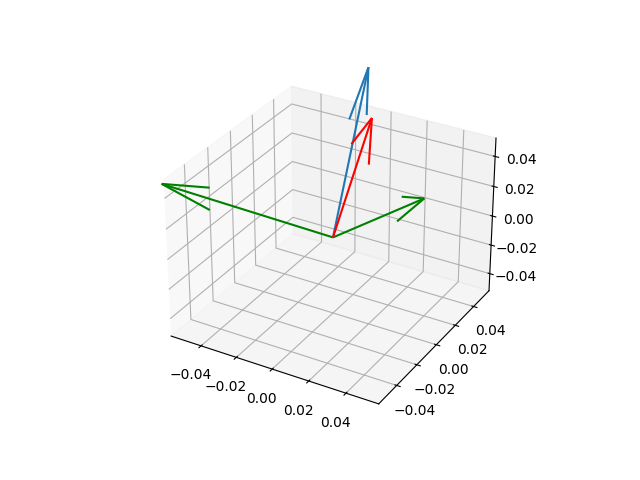

In [ ]:
print(simulate2(0,0,10000,1e-4))